In [ ]:
# !jupyter nbconvert zfl2019.ipynb --to slides --post serve 

Machine Learning Course 2019
Pull and/or run the container for the first time with

docker run -d -p 443:8888 -p 6006:6006 -v :/home/myimagery/ --name=crc4 mort/crc4docker

This maps the host directory my_image_folder to the container directory /home/myimagery/ and runs the container in detached mode.

Point your browser to http://localhost:443 to see the Jupyter home page and open notebook zfl2019.ipynb. In order to use Earth Engine scripts, you must authenticate. From the home page open a local terminal and enter
earthengine authenticate

and follow the instructions. This adds authentication information to the container and only has to be done once.

Stop the container with
docker stop crc4

Re-start with
docker start crc4

HTML Version of the course Jupyter notebook

In [2]:
# !pip install earthengine-api

In [5]:
import ee

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWjRE4s_wlKUSYiBLSK__wawyRNNseIO78ngDP3Jn_gIqH58ivWO2NA

Successfully saved authorization token.


In [22]:
cd myimagery/src

/home/myimagery/src


In [27]:
cp -r ../../imagery .

In [28]:
ls

Chapter1.ipynb*     build/                  requirements.txt*
Chapter2.ipynb*     codings.tif*            s1ingest.ipynb*
Chapter3.ipynb*     condaDockerfile*        scripts/
Chapter4.ipynb*     dist/                   setup.py*
Chapter5_1.ipynb*   eeWishart_sav.py*       sim_sar.html*
Chapter5_2.ipynb*   eesardocs.ipynb*        sim_sar.ipynb*
Chapter6.ipynb*     eesardocs.slides.html*  solutions.ipynb*
Chapter7.ipynb*     gohar.ipynb*            testgpucpu.ipynb*
Chapter8.ipynb*     imagery/                tf2_course-master/
Chapter9.ipynb*     imagery_initial/        tf_imad.ipynb*
Dockerfile*         mlpy-3.5.0/             tf_imad_test.ipynb*
Dockerfile_old*     notebook.sh*            tf_logs/
MANIFEST*           oauth2client/           tfexample.ipynb*
atwt.py~*           playground.ipynb*       tfintro.ipynb*
autoencoder.ipynb*  pngs/                   zfl2019.ipynb*
auxil/              prov_means.c*           zfl2019.slides.html*


# Land Use Classification and Machine Learning
## ZFL, Bonn March/April 2019
### Mort Canty

mort.canty@gmail.com

### Outline
Land cover classification of remote sensing imagery is a task which falls into the general category of __pattern recognition__. Pattern recognition problems, in turn, are usually approached by developing appropriate __machine learning algorithms__. Broadly speaking, machine learning involves tasks for which there is no known direct method to compute a desired output from a set of inputs. The strategy adopted is for the computer to learn from a set of representative examples.

In the case of supervised classification, the task can often be seen as one of modeling __probability distributions__.  This is called the __training phase__ of the classification procedure. Then these probabilities are used to classify all of the pixels in the image, a step  referred to as the __generalization phase__.

The course will treat three representative models for supervised classification which involve probability estimation: a __parametric model__ (the Bayes maximum likelihood classifier), a __nonparametric model__ (kernel density estimation), and a __semiparametric or mixture model__ (the feed-forward neural network or FFN). In addition statistical methods for accuracy assessment and model comparison will be discussed.

The theory will be illustrated with Python programs for classification and evaluation, both for local processing as well as on the __Google Earth Engine__. In the case of neural networks, __deep learning__ techniques with __TensorFlow__ will be introduced.

### Software

https://mortcanty.github.io/CRC4Docker/

https://docs.docker.com/

### References

https://www.crcpress.com/Image-Analysis-Classification-and-Change-Detection-in-Remote-Sensing-With/Canty/p/book/9781138613225

https://www.amazon.de/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291/ref=sr_1_1?ie=UTF8&qid=1550754549&sr=8-1&keywords=geron+hands-on+machine

In [23]:
import warnings
# these are innocuous but irritating
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
# enable in-line graphics
%matplotlib inline

### The reference ASTER image

In [29]:
!ls imagery | grep AST

AST_20010409
AST_20010409.hdr
AST_20010730
AST_20010730.hdr
AST_20050911
AST_20050911.hdr
AST_20070501
AST_20070501.hdr
AST_20070501_pca.tfw
AST_20070501_pca.tif
AST_20070501_pca_classprobs.tif
AST_3N
AST_3N.hdr
AST_DEM
AST_DEM.hdr


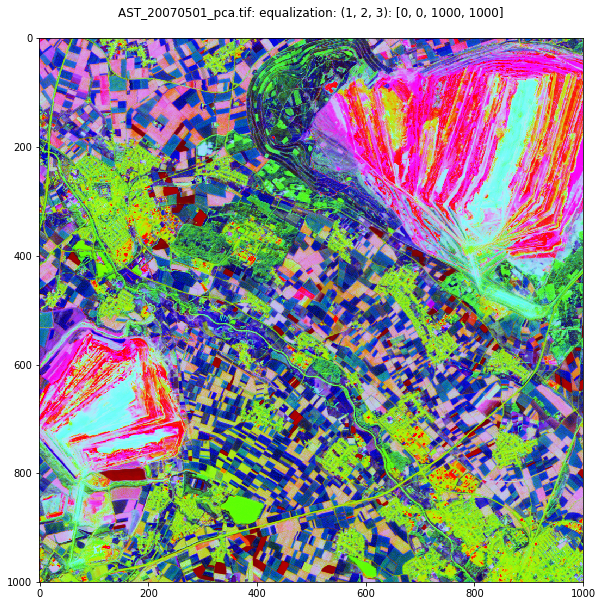

In [30]:
run scripts/dispms -f imagery/AST_20070501_pca.tif -p [1,2,3] -e 4

## Training data acquired on 1.5.2007

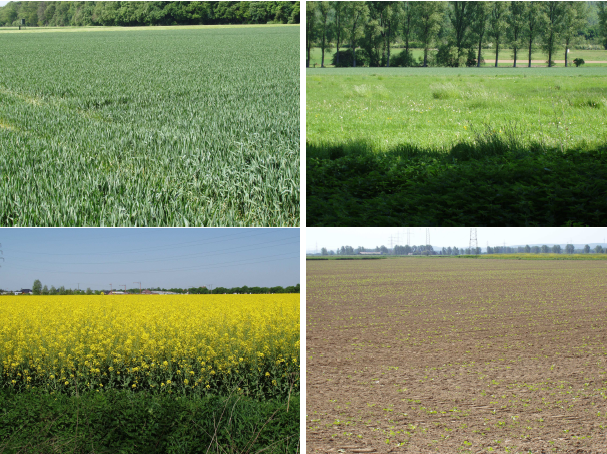

In [31]:
from IPython.display import Image
Image(filename="pngs/fig1.png",width=600,height=600)

The training regions are in ENVI shapefiles in the imagery directory:

In [32]:
!ls imagery | grep train

train.dbf
train.prj
train.roi
train.shp
train.shx
train.txt
train_.dbf
train_.evf
traindata.csv


In [33]:
!cat imagery/train.txt | grep 'ROI name'

and these have been uploaded to GEE as a table in the shared Asset

    users/mortcanty/supervisedclassification/train
    
together with the 9-band ASTER PCA image 

    users/mortcanty/supervisedclassification/AST_20070501_pca

Here we sample the training regions to get a feature collection of training data:

In [34]:
import ee
ee.Initialize()

# first 4 principal components of ASTER image
image = ee.Image('users/mortcanty/supervisedclassification/AST_20070501_pca') \
            .select(0,1,2,3)

# training data
table = ee.FeatureCollection('users/mortcanty/supervisedclassification/train')
trainData = image.sampleRegions(table,['CLASS_ID'])

print trainData.size().getInfo()  
s = set(zip(table.aggregate_array('CLASS_NAME').getInfo(),table.aggregate_array('CLASS_ID').getInfo()))
list(s)

7173


[(u'TAGEBAU [W', u'9'),
 (u'SIEDLUNG [', u'3'),
 (u'WASSER [BL', u'0'),
 (u'LAUBWALD [', u'8'),
 (u'RAPS [YELL', u'1'),
 (u'GETREIDE [', u'6'),
 (u'RUEBEN [CY', u'2'),
 (u'GEWERBE [M', u'4'),
 (u'NADELWALD', u'5'),
 (u'GRAS [RED2', u'7')]

## Bayes Maximum Likelihood Classifier (parametric model)

#### Decision rule

$$
  g \hbox{ is in class } k\hbox{ provided } Pr(k\mid g) \ge Pr(j\mid g)\hbox{  for all } j=1\dots K
$$

#### Bayes' Rule

$$
Pr(k\mid g) =\ \ ? \quad\to \quad Pr(k\mid g) \approx Pr(k) \quad\to \quad  Pr(k\mid g) = {p(g\mid k)\over p(g)} Pr(k)
$$

#### All priors equal

$$
  g \hbox{ is in class } k\hbox{ provided } p(g\mid k) \ge p(g\mid j)\hbox{  for all } j=1\dots K
$$

#### Gaussian model assumption

$$
p(g\mid k)={1\over (2\pi)^{N/2}\vert\Sigma_k\vert^{1/2}}\exp\left(
-{1\over 2} (g-\mu_k)^\top \Sigma_k^{-1} (g-\mu_k) \right).
$$

#### Taking logarithm and ignoring class-independent terms

$$
 g \hbox{ is in class } k\hbox{ provided } d_k(g) \ge d_j(g)\hbox{ for all } j=1\dots K.
$$

#### where 

$$
d_k(g) = -\log\vert\Sigma_k\vert - (g-\mu_k)^\top \Sigma_k^{-1} (g-\mu_k).
$$


## Training data separability


#### The Bayes error for a binary classifier:

$$
\epsilon = \int\min[\ Pr(1\mid g),Pr(2\mid g)\ ]p(g)dg = \int\min[\ p(g\mid 1)Pr(1),p(g\mid 2)Pr(2)\ ]dg.
$$

#### If the two probability densities are assumed to be Gaussian, we get 

$$
\epsilon\le\epsilon_B =\sqrt{Pr(1)Pr(2)}\int \sqrt{p(g\mid 1)p(g\mid 2)}\ dg = \sqrt{Pr(1)Pr(2)}\ e^{-B},
$$

#### where the Bhattacharyya distance between is:

$$
B = {1\over 8}(\mu_2-\mu_1)^\top \left[{\Sigma_1+\Sigma_2\over 2}\right]^{-1} (\mu_2-\mu_1)
+{1\over 2}\log\left({\left|\Sigma_1+\Sigma_2\right|/2\over \sqrt{|\Sigma_1||\Sigma_2|}}\right).
$$

#### Larger values of $B$ imply smaller Bayes error. The Jeffries-Matusita separability measure is defined in terms of $B$ as

$$
J = 2(1-e^{-B})
$$

#### A function to calculate the Jeffries-Matusita separability on the GEE:

In [35]:
def jmsep(class1,class2,image,table): 
    ''' Jeffries-Matusita separability '''    
#  mean and covariance of class1
    table1 = table.filter(ee.Filter.eq('CLASS_ID',str(class1))) 
    m1 = image.reduceRegion(ee.Reducer.mean(),table1).toArray() 
    s1 = image.toArray().reduceRegion(ee.Reducer.covariance(),table1).toArray()
#  mean and covariance of class2    
    table2 = table.filter(ee.Filter.eq('CLASS_ID',str(class2)))
    m2 = image.reduceRegion(ee.Reducer.mean(),table2).toArray()
    s2 = image.toArray().reduceRegion(ee.Reducer.covariance(),table2,15).toArray()
#  difference of means     
    m12 = m1.subtract(m2)  
    m12 = ee.Array([m12.toList()]) # makes 2D matrix, one row and N cols  
#  first term in Bhattacharyya distance
    s12i = s1.add(s2).divide(2).matrixInverse()
    B1 = m12.matrixMultiply(s12i.matrixMultiply(m12.matrixTranspose())).divide(8)
#  second term    
    ds1 = s1.matrixDeterminant()
    ds2 = s2.matrixDeterminant() 
    ds12 = s1.add(s2).matrixDeterminant()
    B2 = ds12.divide(2).divide(ds1.multiply(ds2).sqrt()).log().divide(2)
#  add them together    
    B = ee.Number(B1.add(B2).project([0]).toList().get(0))
#  J-M separability
    return ee.Number(1).subtract(ee.Number(1).divide(B.exp())).multiply(2)

In [36]:
print jmsep(3,4,image,table).getInfo()

1.82841730902


In [37]:
# Band mean values for the training data, illustrating iteration over an ee.List object
def band_mean(current,prev):
    current = ee.String(current)
    prev = ee.Dictionary(prev)
    trainData = ee.FeatureCollection(prev.get('trainData'))
    class_id = prev.get('class_id')
    means = ee.List(prev.get('means'))
    mu = trainData.filter(ee.Filter.eq('CLASS_ID',class_id)).aggregate_mean(current)
    return ee.Dictionary({ 'trainData':trainData,'class_id':class_id,'means':means.add(mu) })

def class_mean(trainData,class_id,bandNames):
    first = ee.Dictionary({'trainData':trainData,'class_id':str(class_id),'means':ee.List([])})
    return ee.Dictionary(bandNames.iterate(band_mean,first)).get('means')

In [38]:
mu = ee.Array(class_mean(trainData,9,image.bandNames()))
print mu.getInfo()    

[31.329666699089675, 4.0067963564760785, 3.5330487996783466, -0.9069676977568889]


### Naive Bayes on the GEE

In [40]:
jet = 'black,blue,cyan,yellow,red,brown'

# training data
table = ee.FeatureCollection('users/mortcanty/supervisedclassification/train')
trainData = image.sampleRegions(table,['CLASS_ID'])

# rename the class ids in the trainData feature collection from strings to integers
trainData = trainData.remap(['0','1','2','3','4','5','6','7','8','9'],[0,1,2,3,4,5,6,7,8,9],'CLASS_ID')
    
# train a naive Bayes classifier
# https://groups.google.com/g/google-earthengine-announce/c/rCu4FP_Cn08/m/DqC192X9BAAJ
classifier = ee.Classifier.smileNaiveBayes() # continuousNaiveBayes()
trained = classifier.train(trainData,'CLASS_ID',image.bandNames())

# classify the image and display    
classified = image.classify(trained)
url = classified.select('classification').getThumbURL({'min':0,'max':9,'palette':jet})
Image(url=url)

### Gaussian Bayes Maximum Likelihood with the classify.py script

In [41]:
run scripts/classify -h


Usage: 
--------------------------------------

Supervised classification of multispectral images

python scripts/classify.py [OPTIONS] filename shapefile 

Options:
  -h            this help
  -p  <list>    RGB band positions to be included
                (default all) e.g. -p [1,2,3]
  -a  <int>     algorithm  1=MaxLike
                           2=Gausskernel
                           3=NNet(backprop)
                           4=NNet(congrad)
                           5=NNet(Kalman)
                           6=Dnn(tensorflow)
                           7=SVM
  -e  <int>     number of epochs (default 100)
  -t  <float>   fraction for training (default 0.67)
  -v            use validation (reserve half of training
                   data for validation)  
  -P            generate class probability image (not
                         available for MaxLike)
  -n            suppress graphical output
  -L  <list>    list of hidden neurons in each 
                   hidden layer (de

In [42]:
run scripts/classify -p [1,2,3,4] -a 1 imagery/AST_20070501_pca.tif imagery/train.shp

Training with MaxLike
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 0.00219202041626
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 1.72602820396
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_MaxLike.tst
done


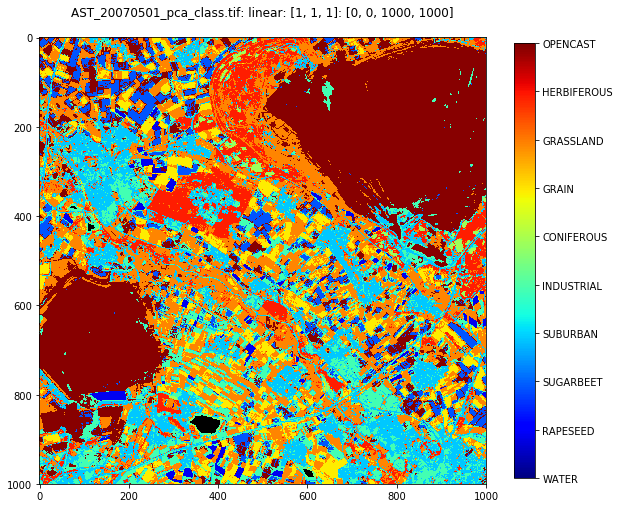

In [43]:
run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c \
-r  "['WATER', 'RAPESEED', 'SUGARBEET', 'SUBURBAN', 'INDUSTRIAL', 'CONIFEROUS', 'GRAIN', 'GRASSLAND', 'HERBIFEROUS', 'OPENCAST']" 

## Gauss Kernel Classifier (non-parametric model)

####  For training vectors $g(\nu)$, $\nu=1\dots m$, the contribution to the probability density at the point $g(\nu)$ from class $k$ is

$$
p(g(\nu)\mid k) = {1\over m_k}\sum_{\{\nu'\mid \ell(\nu') = k\}}
\exp\left(-{\|g(\nu)-g(\nu')\|^2\over 2\sigma^2}\right)
= {1\over m_k}\sum_{\{\nu'\mid \ell(\nu') = k\}}(\mathcal{K})_{\nu\nu'},
$$

#### where $\mathcal{K}$ is an $m\times m$ *Gaussian kernel matrix* and $\ell(\nu)$ is the class label.

#### With the rule, choose class $k$ if

$$
p(g\mid k) \ge p(g\mid j),\quad j=1\dots K,
$$

#### training involves finding the value of $\sigma$ which minimizes the classification error on the training data themselves.

In [ ]:
#run scripts/classify -p [1,2,3,4] -a 2 -P imagery/AST_20070501_pca.tif imagery/train.shp

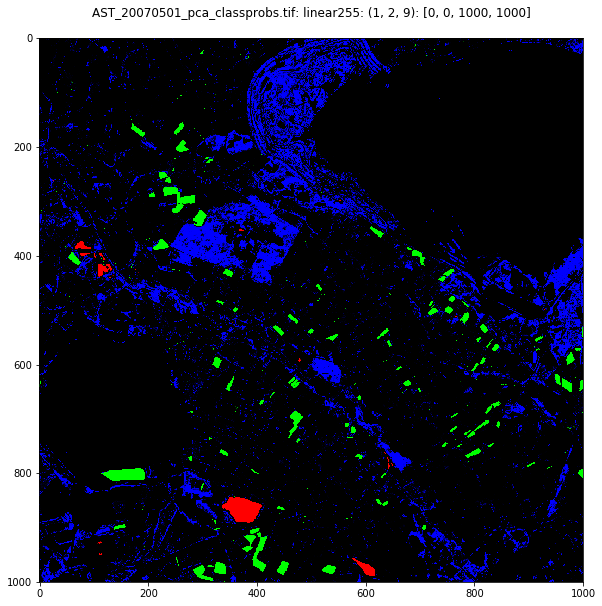

In [44]:
run scripts/dispms -f imagery/AST_20070501_pca_classprobs.tif -p [1,2,9] -e 1

## Feed Forward Neural Network (mixture model)

### Motivation (for two classes of two-dimensional observations)

#### Discriminant function

$$
I(g) = d_1(g) - d_2(g)
$$

$$
g\ \hbox{  is class }\cases{1 & if $I(g)\ge0$\cr 2 & if $I(g)<0$.}
$$

#### Simplest discriminant

$$
I(g) = w_0 + w_1g_1+w_2g_2
$$

#### Decision boundary $I(g)=0)$

$$
g_2 = -{w_1\over w_2}g_1-{w_0\over w_2},
$$


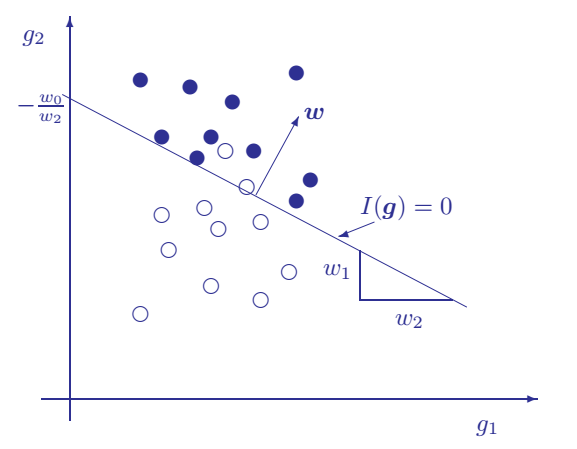

In [45]:
Image(filename="pngs/fig2.png",width=600,height=600)

#### For N-dimensional observations this becomes an *oriented hyperplane*

$$
I(g) = w_0+w_1g_1+\dots+w_Ng_N = w^\top g+w_0
$$

#### This can be represented graphically as a *perceptron* or *artificial neuron*

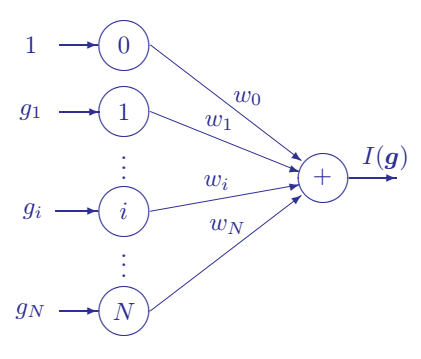

In [46]:
Image(filename="pngs/fig3.png",width=600,height=600)

#### Some jargon:

$g_1\dots g_N$ __input signals__

$w_1\dots W_N$ __synaptic weights__

$w_0$ __bias__

$I(g)$ __output signal__, which is modified by a non-linear __activation function__ such as

$$
f(g) = {1\over 1 + e^{-I(g)}}
$$

#### For just two Gaussian classes,  $\Sigma_1=\Sigma_2$, it is easy to show (text, Chapter 6) that

$$
Pr(1\mid g) = {p(g\mid 1)Pr(1)\over p(g\mid 1)Pr(1)+p(g\mid 2)pr(2)} = {1\over 1 + e^{-I(g)}} = f(g)
$$

We expect that the output signal $f(g)$ of the neuron will not only discriminate
between the two classes,  __but also  that it will approximate the posterior
class membership probability__ $Pr(1\mid g)$.

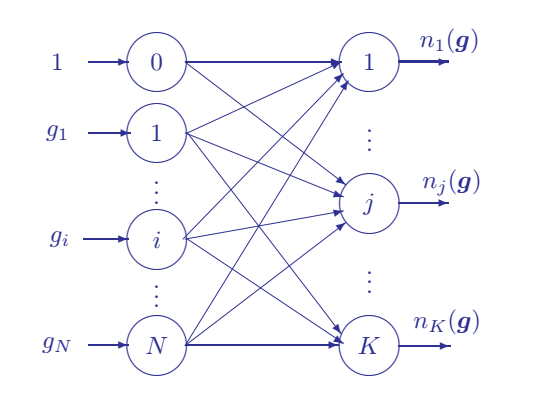

In [47]:
Image(filename="pngs/fig4.png",width=600,height=600)

__There are $K$ neurons (the circles on the right), each of which calculates its own discriminant__

$$
n_j(g)=f(I_j(g)),\  j=1\dots K.
$$

$$
k = \arg\max_j n_j(g).
$$

__For the $j$th neuron,__

$$
w_j = (w_{0j},w_{1j}\dots w_{Nj})^\top,
$$

__and, for the whole network,__

$$
W = (w_1,w_2\dots w_K) = \pmatrix{ w_{01} & w_{02} & \cdots & w_{0K}\cr
                                                   w_{11} & w_{12} & \cdots & w_{1K}\cr
                                                   \vdots & \vdots & \ddots & \vdots\cr
                                                   w_{N1} & w_{N2} & \cdots & w_{NK} },
$$

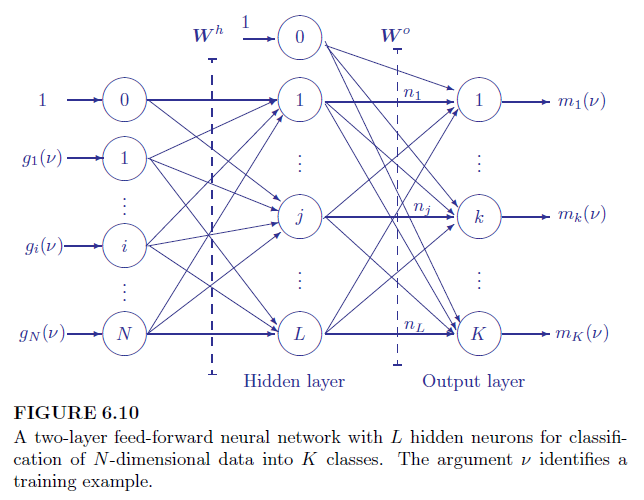

In [48]:
Image(filename="pngs/fig5.png",width=600,height=600)

__Input__

$$
 g(\nu) = (1,g_1(\nu)\dots g_N(\nu))^\top.
$$

__Hidden layer__
$$
n(\nu)=(1,n_1(\nu)\dots n_L(\nu))^\top
$$

$$
n_j(\nu) = f(I^h_j(g(\nu))),\quad j=1\dots L.
$$

$$
I^h_j(g(\nu)) =w^{h\top}_j g(\nu),
$$

$$
n(\nu) = \pmatrix{ 1 \cr f(W^{h\top} g(\nu))}
$$

__Output layer__

$$
m(\nu) = f(W^{o\top}n(\nu))
$$

__Softmax__

$$
m_k(\nu) = {e^{I^o_k(n(\nu))}\over  e^{I^o_1(n(\nu))}+e^{I^o_2(n(\nu))}+\dots + e^{I^o_K( n(\nu))}}
$$

__where__

$$
I^o_k(n(\nu)) = w^{o\top}_k n(\nu), \quad k=1\dots K
$$



__Bishop (1995):__

__Two-layer, feed-forward networks can approximate arbitrarily well any functional continuous mapping from one
finite dimensional space to another, provided the number of hidden units is sufficiently large. ...
An important corollary of this result is, that in the context of a classification problem, networks
with sigmoidal non-linearities and two layers of weights can approximate any decision boundary to
arbitrary accuracy. ... More generally, the capability of such networks to approximate general smooth
functions allows them to model posterior probabilities of class membership.__

### Cost function (catagorical cross-entropy)

__Training set__

$$
\mathcal{T}=\{(g(\nu),\ell(\nu))\mid \nu=1\dots m\},
$$

__"One-hot" encoding__

$$
\ell(\nu) = (0\dots 0,1,0\dots 0)^\top
$$

__Training: Maximize the probability of observing the earch training example (definition of conditional proabability)__

$$
Pr(g(\nu),\ell(\nu)) = Pr(\ell(\nu)\mid g(\nu))\Pr(g(\nu)) = \prod_{k=1}^K [\ m_k(g(\nu))\ ]^{\ell_k(\nu)}
$$

__for example:__

$$
Pr((1,0\dots 0)^\top \mid g) = m_1(g)^1 \cdot m_2(g)^0 \cdots m_K( g)^0 = m_1(g),
$$



__Take negative logarithm, and drop terms independent of the synaptic weights__

$$
E(W^h,W^o) = - \sum_{k=1}^K  \ell_k(\nu)\log [m_k(g(\nu))] \to \min
$$

__In vector notation__

$$
E(\nu) = - \ell(\nu)^\top\log[m(\nu)]
$$

#### Backpropagation algorithm (stochastic)


1. Initialize the synaptic weights with random numbers and set
$\nu$ equal to a random integer in the interval $[1,m]$.

2. Choose training pair $(g(\nu),\ell(\nu))$ and
determine the output response $m(\nu)$ of the network.

3. For $k=1\dots K$ and $j=0\dots L$, replace $w^o_{jk}$ with
$w^o_{jk}-\eta{\partial E(\nu)\over\partial w^o_{jk}}$.

4. For $j=1\dots L$ and $i=0\dots N$, replace $w^h_{ij}$ with
$w^h_{ij}-\eta{\partial E(\nu)\over\partial w^h_{ij}}$.

5. If $\sum_\nu E(\nu)$ ceases to change significantly, stop,
otherwise set $\nu$ equal to a new random integer in $[1,m]$ and go to step 2.

This is a __gradient descent__ algorithm. If we evaluate the parial derivatives we get

For step 3:

$$
W^o(\nu+1) = W^o(\nu) + \eta\ n(\nu) \delta^o(\nu)^\top
$$

$$
\delta^o(\nu) = \ell(\nu)- m(\nu)
$$

For step 4:

$$
W^h(\nu+1) = W^h(\nu) + \eta \ g(\nu)\delta^h(\nu)^\top
$$

where

$$
\pmatrix{0\cr \delta^h(\nu)} =
n(\nu)\cdot(1-n(\nu))\cdot\big( W^{o}\delta^o(\nu)\big) \quad {\bf Backpropagation!}
$$

__Note: In order to calculate the derivatives, the signal must first be fed through the network.__


### DNN: mplementation of a FFN in low-level TensorFlow 

"Deep learning is a particular kind of machine learning that achieves great power and ﬂexibility by representing the world as a nested hierarchy of concepts, with each concept deﬁned in relation to simpler concepts, and more abstract representations computed in terms of less abstract ones."

##### TensorFlow is not (yet) available on the GEE

#### Exporting train/test data from GEE to Google Drive for classification with TensorFlow

In [49]:
import ee
ee.Initialize()

# first 4 principal components of ASTER image
image = ee.Image('users/mortcanty/supervisedclassification/AST_20070501_pca') \
            .select(0,1,2,3)

# training data
table = ee.FeatureCollection('users/mortcanty/supervisedclassification/train')
trainData = image.sampleRegions(table,['CLASS_ID'])

# a column of random numbers in [0,1]
trainTestData = trainData.randomColumn('rand',seed=12345) 
    
# filter on the random column to split into training and test
# feature collections in the ration of 2:1
trainData = trainTestData.filter(ee.Filter.lt('rand',0.67))
testData = trainTestData.filter(ee.Filter.gte('rand',0.67))

print 'train pixels: %i'%trainData.size().getInfo()
print 'test pixels:  %i'%testData.size().getInfo()    

# Export feature collections as csv files
gdexport = ee.batch.Export.table.toDrive(trainData,description='driveexporttask',folder= 'EarthEngineImages',fileNamePrefix='traindata')    
gdexport.start() 

gdexport = ee.batch.Export.table.toDrive(testData,description='driveexporttask',folder= 'EarthEngineImages',fileNamePrefix='testdata')    
gdexport.start()  

train pixels: 4835
test pixels:  2338


#### < Download the CSV files from Google Drive to imagery folder>

In [50]:
!ls imagery | grep csv

testdata.csv
traindata.csv


Read in the CSV file as Pandas dataframes

In [51]:
import pandas as pd

dftrain = pd.read_csv('imagery/traindata.csv')
dftest = pd.read_csv('imagery/testdata.csv')
print dftrain.head(5)

             system:index  CLASS_ID         b1         b2        b3        b4  \
0  0000158ce05169d11f52_0         4  13.740433   5.475265 -3.624691  1.450970   
1  0000158ce05169d11f52_1         4  18.249540  20.890528 -2.816043  1.302701   
2  0000158ce05169d11f52_2         4  20.820412  11.892617 -2.580968  2.478941   
3  0000158ce05169d11f52_3         4  22.043953   0.136678 -1.816418  2.284913   
4  0000158ce05169d11f52_4         4  19.932983  25.459732 -5.796450  1.017232   

       rand  .geo  
0  0.039156   NaN  
1  0.410016   NaN  
2  0.210391   NaN  
3  0.592140   NaN  
4  0.476564   NaN  


Convert relevant columns to numpy arrays

In [52]:
Gstrn = dftrain.values[:,2:6]
lstrn = dftrain.values[:,1]

Gstst = dftest.values[:,2:6]
lstst = dftest.values[:,1]

print Gstrn.shape
print lstrn.shape
print Gstst.shape
print lstst.shape

(4905, 4)
(4905,)
(2268, 4)
(2268,)


#### Digression: tfintro.ipynb

#### Now setup the DNN

In [53]:
import tensorflow as tf
from datetime import datetime

# tensorflow execution graph

tf.reset_default_graph()

# placeholders
Gs = tf.placeholder(tf.float32,shape=(None,4))
ls = tf.placeholder(tf.int64,shape=(None))
# hidden layer with rectified linear units (relu) 
hidden=tf.layers.dense(Gs,10,activation=tf.nn.relu)
# output layer
logits=tf.layers.dense(hidden,10)
# cross entropy cost function
xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=ls,logits=logits)
cost=tf.reduce_mean(xentropy)
# training algorithm with 0.01 learning rate
optimizer=tf.train.GradientDescentOptimizer(0.01)
training_op=optimizer.minimize(cost)
# variables initializer 
init=tf.global_variables_initializer()
# accuracy evaluation
correct=tf.nn.in_top_k(logits,ls,1)
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
# saver
saver = tf.train.Saver()
# logger
cost_summary = tf.summary.scalar('COST',cost)

#### Training and testing

In [54]:
%%time
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir = 'tf_logs/run-'+str(now)
file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())
with tf.Session() as sess:
    init.run()
    for epoch in range(5000):
        if epoch % 200 ==0:
            summary_str = cost_summary.eval(feed_dict={Gs:Gstrn,ls:lstrn})
            file_writer.add_summary(summary_str,epoch)
#        training_op.eval(feed_dict={Gs:Gstrn,ls:lstrn})
        sess.run(training_op,feed_dict={Gs:Gstrn,ls:lstrn})
    acc = accuracy.eval(feed_dict={Gs:Gstst,ls:lstst})
    save_path = saver.save(sess,'imagery/dnn.ckpt')
file_writer.close()
print 'Test accuracy: %f'%acc

Test accuracy: 0.915785
CPU times: user 31.5 s, sys: 9.93 s, total: 41.4 s
Wall time: 19.8 s


In [55]:
!tensorboard --logdir tf_logs/

TensorBoard 1.13.1 at http://5bb8c5167172:6006 (Press CTRL+C to quit)
^C


#### Prediction, first read in the entire image

In [56]:
import auxil.readshp as rs
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import matplotlib.pyplot as plt
import numpy as np

infile='imagery/AST_20070501_pca.tif'
gdal.AllRegister()
inDataset = gdal.Open(infile,GA_ReadOnly)
# read entire image
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize  
Gs_all = np.zeros((cols*rows,4))
for b in range(4):
    band = inDataset.GetRasterBand(b+1)
    Gs_all[:,b] = band.ReadAsArray(0,0,cols,rows)\
                          .astype(float).ravel()    

#### Now restore the saved model and set up evaluation of the output layer with the full image

In [57]:
with tf.Session() as sess:
    saver.restore(sess,'imagery/dnn.ckpt')
    Z = logits.eval(feed_dict={Gs:Gs_all})
    cls = np.argmax(Z,1)  

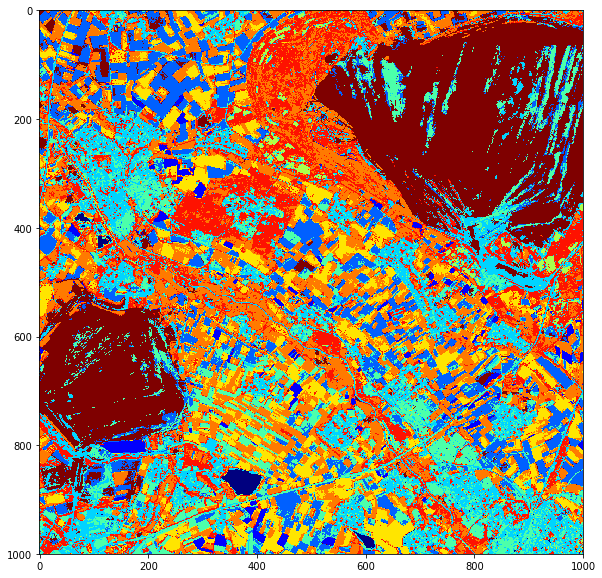

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.reshape(cls/10.0,(rows,cols)),cmap='jet')

### Implementation in high-level TensorFlow (keras)
__Note:__ Here we read the ENVI shapefiles directly

In [59]:
run scripts/classify -p [1,2,3,4] -a 6 -n -e 1000 -L [10,10,10] imagery/AST_20070501_pca.tif imagery/train.shp

Training with Dnn(tensorflow)
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 224.287681818
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 17.8103079796
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_Dnn(tensorflow).tst
done


<Figure size 432x288 with 0 Axes>

## Digression: Convolutional Neural Networks (CNN)

__FFN/DNN for spectral classification__

__CNN for spatial classification (object recognition)__

https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a

### Prepare training/test/validation data

4431872/4422102 [==============================] - 1s 0us/step
('x_train shape:', (60000, 28, 28), 'y_train shape:', (60000,))


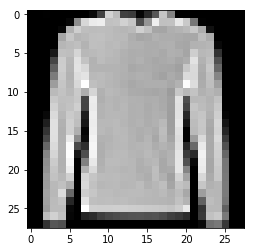

In [60]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

def gray_background(img):
    return np.where(img>100,img,100)

# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#x_train = np.array(map(gray_background,x_train))
#x_test = np.array(map(gray_background,x_test))

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# normalize the train/test data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

plt.imshow(x_test[55],cmap='gray',vmin=0,vmax=1)

In [61]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

('x_train shape:', (55000, 28, 28, 1), 'y_train shape:', (55000, 10))
(55000, 'train set')
(5000, 'validation set')
(10000, 'test set')


### Create the model graph structure

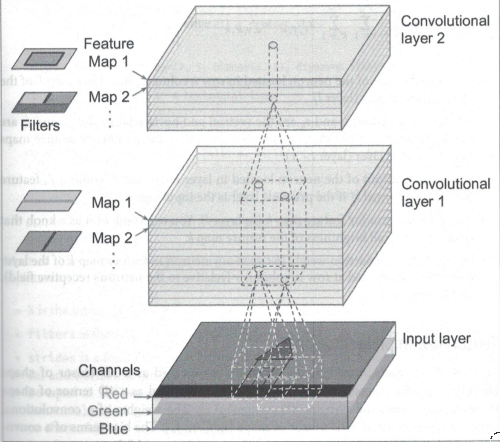

In [62]:
from IPython.display import Image
Image(filename="pngs/fig6.png",width=600,height=600)

In [63]:
model = tf.keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
__________

In [73]:
# conv2d: (2 times 2 kernel pixels + 1 bias) times 64 filters
print (2*2 + 1)*64

# conv2d_1: (2 times 2 kernel pixels times 64 filters + 1 bias) times 32 filters
print (2*2*64 + 1)*32

# flatten: 7*7*32
print 7*7*32

#dense
print 256*(1568+1)

# dense_1
print 10*(256+1)

320
8224
1568
401664
2570


#### Compile the model

In [65]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

### Run the model

In [66]:
%%time
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir = 'tf_cnn/run-'+str(now)
checkpointer = ModelCheckpoint(filepath='imagery/model.weights.best.hdf5', verbose = 1, save_best_only=True)
tensorboardlog = TensorBoard(logdir)

model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=5,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer,tensorboardlog])

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
54976/55000 [============================>.] - ETA: 0s - loss: 0.5982 - acc: 0.7785
Epoch 00001: val_loss improved from inf to 0.37702, saving model to imagery/model.weights.best.hdf5
55000/55000 [==============================] - 38s 690us/sample - loss: 0.5980 - acc: 0.7785 - val_loss: 0.3770 - val_acc: 0.8632
Epoch 2/5
54976/55000 [============================>.] - ETA: 0s - loss: 0.4159 - acc: 0.8493
Epoch 00002: val_loss improved from 0.37702 to 0.32130, saving model to imagery/model.weights.best.hdf5
55000/55000 [==============================] - 38s 683us/sample - loss: 0.4161 - acc: 0.8492 - val_loss: 0.3213 - val_acc: 0.8842
Epoch 3/5
54976/55000 [============================>.] - ETA: 0s - loss: 0.3739 - acc: 0.8637
Epoch 00003: val_loss improved from 0.32130 to 0.29331, saving model to imagery/model.weights.best.hdf5
55000/55000 [==============================] - 37s 669us/sample - loss: 0.3740 - acc: 0.8637 - val_lo

In [ ]:
!tensorboard --logdir tf_cnn

### Test the model

In [67]:
# Load the weights with the best validation accuracy
model.load_weights('imagery/model.weights.best.hdf5')

# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print '\nTest accuracy:', score[1]

# save the model
# model.save('imagery/model.hdf5')


Test accuracy: 0.8953


### Apply the model to find  articles of clothing  lost from a flight over Jülich   ;-)

In [68]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Float32
import auxil.auxil1 as auxil

# make and save a test image
gdal.AllRegister()             
inDataset = gdal.Open('imagery/LE7_20010525',GA_ReadOnly)     
tstimg = auxil.lin2pcstr(inDataset.GetRasterBand(1).ReadAsArray())

for i in range(3):
    for j in range(3):
        ii = np.random.randint(100,900)
        jj = np.random.randint(100,900)
        tstimg[ii:ii+28,jj:jj+28] = np.reshape(255*x_train[np.random.randint(0,5000)],(28,28))

driver = inDataset.GetDriver() 
outDataset = driver.Create('imagery/tstimg',1000,1000,1,GDT_Float32) 
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(tstimg,0,0) 
outBand.FlushCache()
outDataset = None
inDataset = None

In [69]:
# restore model
model =tf.keras.models.load_model('imagery/model.weights.best.hdf5')

In [70]:
# read in the test image
infile = 'imagery/tstimg'
gdal.AllRegister()             
inDataset = gdal.Open(infile,GA_ReadOnly)       
imagetst = inDataset.GetRasterBand(1).ReadAsArray()/255.
inDataset = None

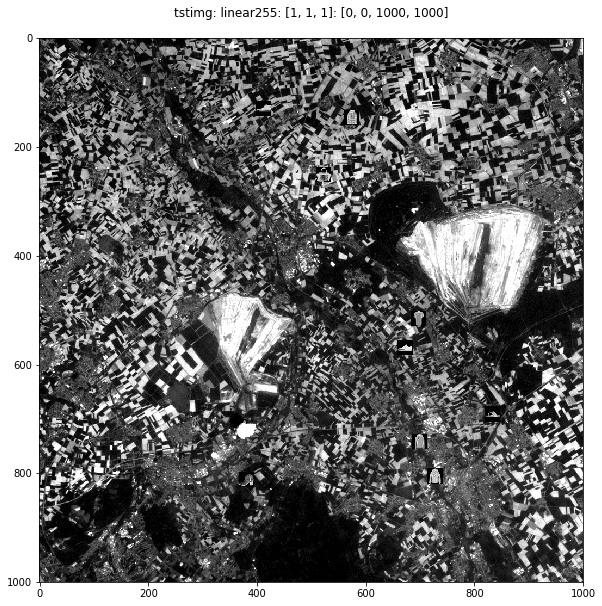

<Figure size 432x288 with 0 Axes>

In [71]:
run scripts/dispms -f 'imagery/tstimg' -e 1 

In [72]:
import sys
classprobimg = np.zeros((1000,1000))
for i in range(14,1000-14):
    if i % 100 == 0:
        print i
    tiles = np.array([np.reshape(imagetst[i-14:i+14,j-14:j+14],(28,28,1)) for j in range(14,1000-14)])
    classprobimg[i,0:1000-28] = map(np.max,model.predict(tiles))

100
200
300
400
500
600
700
800
900


In [74]:
outDataset = driver.Create('imagery/signal',1000,1000,3,GDT_Float32) 
signal = np.where(classprobimg>0.999,classprobimg,0)
sigimg = np.zeros((3,1000,1000))
sigimg[0,:,:] = signal
for i in range(3):
    outBand = outDataset.GetRasterBand(i+1)
    outBand.WriteArray(sigimg[i,:,:],0,0) 
    outBand.FlushCache()
outDataset = None

auxil/auxil1.py:507: RuntimeWarning: invalid value encountered in divide
  tmp =  (arr-rng[0])*255.0/(rng[1]-rng[0])
auxil/auxil1.py:508: RuntimeWarning: invalid value encountered in less
  tmp = np.where(tmp<0,0,tmp)
auxil/auxil1.py:509: RuntimeWarning: invalid value encountered in greater
  tmp = np.where(tmp>255,255,tmp)


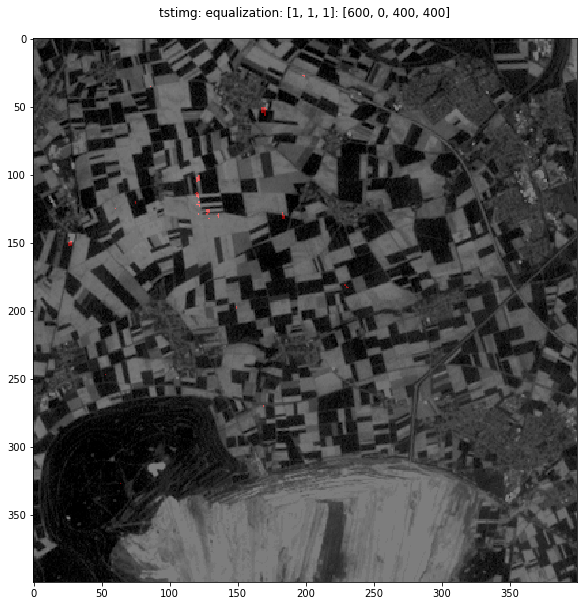

In [75]:
run scripts/dispms -f  imagery/tstimg -e 4 -d [600,0,400,400] -F imagery/signal -E 2 -P [1,2,3] -o 0.5 -D [600,0,400,400]

## Digression: Autoencoder Neural Networks

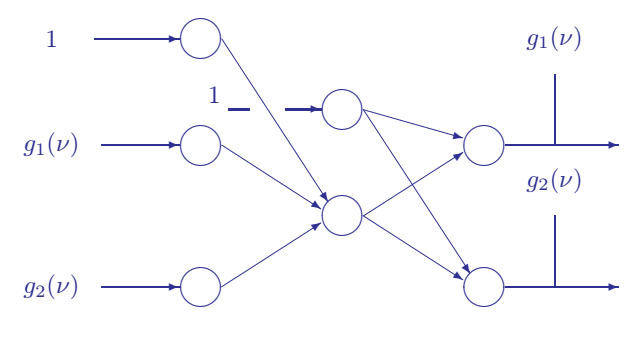

In [76]:
Image(filename="pngs/fig7.png",width=600,height=600)

In [77]:
import tensorflow as tf
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly,GDT_Float32
from datetime import datetime
import numpy as np

# read entire 9-band image
infile='imagery/AST_20070501'
gdal.AllRegister()
inDataset = gdal.Open(infile,GA_ReadOnly)
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize  
bands = inDataset.RasterCount
Gs = np.zeros((cols*rows,bands))
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    Gs[:,b] = band.ReadAsArray(0,0,cols,rows)\
                          .astype(float).ravel() 

# autoencode to three principal components    
n_inputs = bands
n_hidden = 3
n_outputs = n_inputs
n_iterations = 1000

# tensorflow graph
tf.reset_default_graph()    
X = tf.placeholder(tf.float32,shape=[None,bands]) 
hidden = tf.layers.dense(X,n_hidden)
outputs = tf.layers.dense(hidden,n_outputs)

# mean square loss function
reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))
optimizer = tf.train.AdamOptimizer(0.01)
training_op = optimizer.minimize(reconstruction_loss)
init = tf.global_variables_initializer()
codings = hidden  # the principal components image
recons = outputs  # the reconstructed image
# logger
cost_summary = tf.summary.scalar('ACCURACY',reconstruction_loss)

# run the graph
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir = 'tf_logs/run-'+str(now)
file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        if iteration % 10 ==0:
            summary_str = cost_summary.eval(feed_dict={X:Gs})
            file_writer.add_summary(summary_str,iteration)        
        training_op.run(feed_dict = {X:Gs})
    codings_val = codings.eval(feed_dict = {X:Gs})
    recons_val = recons.eval(feed_dict = {X:Gs})

# output codings (PCs) to disk
driver = gdal.GetDriverByName('GTiff') 
outDataset = driver.Create('imagery/codings.tif',cols,rows,n_hidden,GDT_Float32)    
for k in range(n_hidden):        
    outBand = outDataset.GetRasterBand(k+1)
    outBand.WriteArray(np.reshape(codings_val[:,k],(cols,rows)))
    outBand.FlushCache() 

# output reconstruction to disk
driver = gdal.GetDriverByName('GTiff') 
outDataset = driver.Create('imagery/recons.tif',cols,rows,bands,GDT_Float32)    
for k in range(bands):        
    outBand = outDataset.GetRasterBand(k+1)
    outBand.WriteArray(np.reshape(recons_val[:,k],(cols,rows)))
    outBand.FlushCache() 
inDataset = None
outDataset= None

print 'Done'

Done


In [ ]:
!tensorboard --logdir tf_logs/

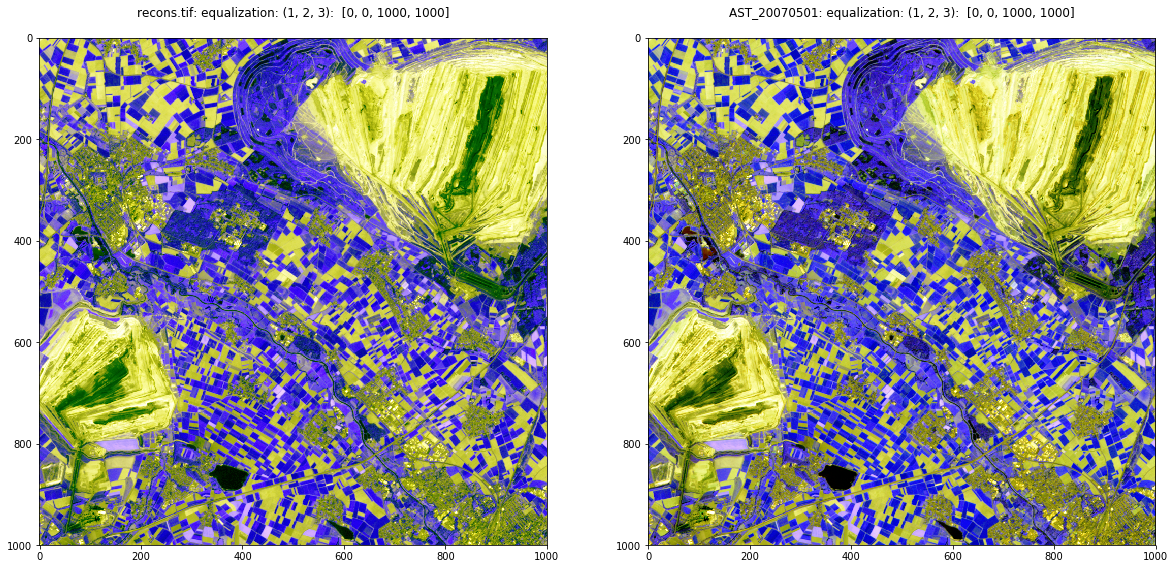

In [78]:
run scripts/dispms -f imagery/recons.tif -p [1,2,3] -e 4 -F imagery/AST_20070501 -P [1,2,3] -E 4

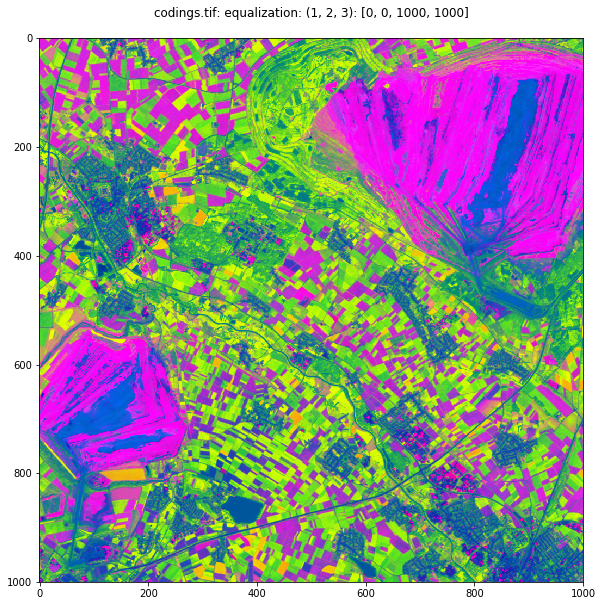

In [79]:
run scripts/dispms -f imagery/codings.tif -p [1,2,3] -e 4

## Classification Model Evaluation and Comparison